In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('Collaborative Filtering').getOrCreate()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
hotel_comments= pd.read_csv("hotel_comments.csv")

In [7]:
hotel_comments.head(3)

,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


In [8]:
hotel_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB


cột num có giá trị là liên tiếp ,không có trùng ->xóa

In [9]:
hotel_comments=hotel_comments.drop(columns=['num'])

In [10]:
hotel_comments.isna().sum()

Hotel ID          0
Reviewer ID       0
Reviewer Name    86
Nationality       0
Group Name        0
Room Type         0
Stay Details      0
Score             0
Score Level       0
Title             0
Body             42
Review Date       0
dtype: int64

dữ liệu Nan
Review Name:86
Body:42

In [11]:
hotel_comments.duplicated(subset= ['Reviewer Name']).sum()

72123

review_name có trùng

->kiểm tra file csv thì có 2 trường hợp như sau:

Không có dữ liệu trùng lặp ở cột review_id ->Điều này có nghĩa là mỗi dòng trong dữ liệu đều có một mã định danh đánh giá duy nhất
cùng 1 reviewer_name:đánh giá nội dung trùng lặp cho cùng 1 hotel_id nhiều lần ->lọc trùng giữ dòng cuối

cùng reviewer_name:đánh giá cho  các hotel_id khác nhau, đây có thể là tình huống một người đã đánh giá nhiều khách sạn khác nhau.hoặc 2 người khác nhau vô tình trùng tên

TH1:cùng 1 reviewer_name:đánh giá nội dung trùng lặp cho cùng 1 hotel_id nhiều lần với cùng tất cả nội dung các cột như nhau ->lọc trùng giữ dòng cuối

In [12]:
columns_to_check = ['Hotel ID','Reviewer Name', 'Nationality', 'Group Name', 'Room Type', 'Stay Details', 'Score', 'Score Level', 'Title', 'Body']

In [13]:
# Tìm các dòng trùng lặp TH1
duplicates = hotel_comments[hotel_comments.duplicated(subset=columns_to_check, keep=False)]
# In các dòng trùng lặp
duplicates.head()

,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024
3,1_1,1_1_4,Nghĩa,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 3 đêm vào Tháng 6 năm 2024,"8,8",Tuyệt vời,Du lịch Nha Trang tại Mường Thanh”,Hôm đi đến lúc về thì mọi thứ trong Khách sạn ...,Đã nhận xét vào 02 tháng 7 2024
4,1_1,1_1_5,Duc,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Ks tốt !”,Khách sạn có vị trí trung tâm và sát biển. Nhâ...,Đã nhận xét vào 16 tháng 6 2024


In [14]:
num_duplicates_1 = hotel_comments.duplicated(subset=columns_to_check, keep=False).sum()
num_duplicates_1

66418

In [15]:
# Loại bỏ các dòng trùng lặp, giữ lại dòng cuối cùng trong mỗi nhóm trùng lặp
hotel_comments_clean = hotel_comments.drop_duplicates(subset=columns_to_check, keep='last')

In [16]:
hotel_comments_clean.shape

(31071, 12)

Sau khi lọc trùng lần 1 còn lại 31071 dòng

TH2:cùng một Reviewer Name đã đánh giá cho các Hotel ID khác nhau nhưng nội dung đánh giá ở tất cả các cột là giống nhau hoàn toàn. Điều này có thể xảy ra vì nhiều lý do, chẳng hạn như người dùng sao chép và dán đánh giá cho nhiều khách sạn hoặc dữ liệu trùng lặp do lỗi nhập liệu.

Cách xử lý:
    Xác định các nhóm trùng lặp: Nhóm các đánh giá có cùng Reviewer Name và nội dung đánh giá giống nhau cho các Hotel ID khác nhau.
    
    review_ID là giá trị duy nhất->nhớm những dòng TH2 thành cùng review_id

In [17]:
# Danh sách các cột để kiểm tra trùng lặp (tất cả các cột đánh giá)
columns_to_check_1 = ['Reviewer Name', 'Nationality', 'Group Name', 'Room Type', 
                    'Stay Details', 'Score', 'Score Level', 'Title', 'Body']


In [18]:
df_fixed = hotel_comments_clean.copy()


In [19]:
# Nhóm theo các cột đánh giá và đếm số lượng dòng trong mỗi nhóm
grouped_df = df_fixed.groupby(columns_to_check_1)

In [20]:
# Lọc các nhóm có nhiều hơn một dòng
duplicates = grouped_df.filter(lambda x: len(x) > 1)

In [21]:
sorted_duplicates = duplicates.sort_values(by='Reviewer Name')
sorted_duplicates.head()

,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
61062,11_25,11_25_124,AKIKO,Nhật Bản,Nhóm,Villa trên đỉnh đồi có hồ bơi riêng,Đã ở 1 đêm vào Tháng 5 năm 2018,"8,0",Tuyệt vời,自然の中のリゾート”,専用のボートでしか行けない自然に囲まれたリゾート。眺望は最高でした。自転車で移動したり、自然...,Đã nhận xét vào 11 tháng 5 2018
47152,6_25,6_25_124,AKIKO,Nhật Bản,Nhóm,Villa trên đỉnh đồi có hồ bơi riêng,Đã ở 1 đêm vào Tháng 5 năm 2018,"8,0",Tuyệt vời,自然の中のリゾート”,専用のボートでしか行けない自然に囲まれたリゾート。眺望は最高でした。自転車で移動したり、自然...,Đã nhận xét vào 11 tháng 5 2018
58032,11_14,11_14_124,AKIKO,Nhật Bản,Nhóm,Villa trên đỉnh đồi có hồ bơi riêng,Đã ở 1 đêm vào Tháng 5 năm 2018,"8,0",Tuyệt vời,自然の中のリゾート”,専用のボートでしか行けない自然に囲まれたリゾート。眺望は最高でした。自転車で移動したり、自然...,Đã nhận xét vào 11 tháng 5 2018
39262,4_30,4_30_64,ALEKSANDR,Thái Lan,Cặp đôi,Deluxe giường đôi có ban công,Đã ở 1 đêm vào Tháng 5 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,"Супер новый отель, стильный и удобный. На завт...",Đã nhận xét vào 02 tháng 7 2024
36173,4_19,4_19_64,ALEKSANDR,Thái Lan,Cặp đôi,Deluxe giường đôi có ban công,Đã ở 1 đêm vào Tháng 5 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,"Супер новый отель, стильный и удобный. На завт...",Đã nhận xét vào 02 tháng 7 2024


In [22]:
for _, group in grouped_df:
    if len(group) > 1:
        # Chọn giá trị 'Reviewer ID' đầu tiên trong nhóm
        reviewer_id= group.iloc[0]['Reviewer ID']
        # Cập nhật 'Reviewer ID' 
        df_fixed.loc[group.index, 'Reviewer ID'] = reviewer_id

In [23]:
# Hiển thị các dòng bị thay đổi
changed_rows = df_fixed[hotel_comments_clean['Reviewer ID'] != df_fixed['Reviewer ID']]
grouped_changed_rows = changed_rows.groupby('Reviewer Name')
for reviewer_name, group in grouped_changed_rows:
    print(f"Reviewer Name: {reviewer_name}")
    print(group)

Reviewer Name: AKIKO
      Hotel ID Reviewer ID Reviewer Name Nationality Group Name  \
58032    11_14    6_25_124         AKIKO    Nhật Bản       Nhóm   
61062    11_25    6_25_124         AKIKO    Nhật Bản       Nhóm   

                                 Room Type                     Stay Details  \
58032  Villa trên đỉnh đồi có hồ bơi riêng  Đã ở 1 đêm vào Tháng 5 năm 2018   
61062  Villa trên đỉnh đồi có hồ bơi riêng  Đã ở 1 đêm vào Tháng 5 năm 2018   

      Score Score Level       Title  \
58032   8,0   Tuyệt vời  自然の中のリゾート”   
61062   8,0   Tuyệt vời  自然の中のリゾート”   

                                                    Body  \
58032  専用のボートでしか行けない自然に囲まれたリゾート。眺望は最高でした。自転車で移動したり、自然...   
61062  専用のボートでしか行けない自然に囲まれたリゾート。眺望は最高でした。自転車で移動したり、自然...   

                           Review Date  
58032  Đã nhận xét vào 11 tháng 5 2018  
61062  Đã nhận xét vào 11 tháng 5 2018  
Reviewer Name: ALEKSANDR
      Hotel ID Reviewer ID Reviewer Name Nationality Group Name  \
39262     4_30     4_19_6

In [24]:
# in toàn bộ DataFrame đã sửa đổi
print("DataFrame đã sửa đổi:")
print(df_fixed)

DataFrame đã sửa đổi:
      Hotel ID Reviewer ID Reviewer Name    Nationality          Group Name  \
1033       1_1    1_1_1034            LÊ       Việt Nam   Gia đình có em bé   
1034       1_1    1_1_1035        Nguyen       Việt Nam             Cặp đôi   
1035       1_1    1_1_1036          Dũng       Việt Nam             Cặp đôi   
1036       1_1    1_1_1037        Nguyên       Việt Nam             Cặp đôi   
1037       1_1    1_1_1038          Thai       Việt Nam   Gia đình có em bé   
...        ...         ...           ...            ...                 ...   
80309    43_29     43_29_7          Hung       Việt Nam             Cặp đôi   
80310    43_29     43_29_8           Hữu       Việt Nam  Gia đình có trẻ em   
80311    43_29     43_29_9          Thuy       Việt Nam             Cặp đôi   
80312    43_29    43_29_10        nguyen       Việt Nam             Cặp đôi   
80313    43_29    43_29_11          Tran  Bắc Macedonia             Cặp đôi   

                          Roo

In [25]:
df_fixed.to_csv("group_rw_id.csv",index=False)

In [26]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31071 entries, 1033 to 80313
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Hotel ID       31071 non-null  object
 1   Reviewer ID    31071 non-null  object
 2   Reviewer Name  31043 non-null  object
 3   Nationality    31071 non-null  object
 4   Group Name     31071 non-null  object
 5   Room Type      31071 non-null  object
 6   Stay Details   31071 non-null  object
 7   Score          31071 non-null  object
 8   Score Level    31071 non-null  object
 9   Title          31071 non-null  object
 10  Body           31053 non-null  object
 11  Review Date    31071 non-null  object
dtypes: object(12)
memory usage: 4.1+ MB


In [27]:
hotel_comments_clean = df_fixed

In [28]:
# # Xóa các dòng trùng lặp dựa trên Reviewer Name và tất cả các cột nội dung
# hotel_comments_clean = hotel_comments_clean.drop_duplicates(subset=columns_to_check_1, keep='last')

In [29]:
hotel_comments_clean.shape

(31071, 12)

Sau khi lọc trùng lần 2 còn lại 26920 dòng

TH3:Review_Name vô tình trùng tên,trường hợp này chỉ kiểm tra số lượng,không xử lý gì thêm

In [30]:
# Đếm số lần xuất hiện của mỗi Reviewer Name
reviewer_name_counts = hotel_comments_clean['Reviewer Name'].value_counts()

In [31]:
# Lọc ra những Reviewer Name xuất hiện nhiều hơn 1 lần
duplicate_reviewers = reviewer_name_counts[reviewer_name_counts > 1]
print(duplicate_reviewers)

Reviewer Name
Nguyễn     583
Nguyen     498
Thi        373
Minh       309
Thanh      308
          ... 
Ali          2
진            2
Alessio      2
XIAODI       2
bích         2
Name: count, Length: 3471, dtype: int64


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Lấy top 20 tên phổ biến nhất
top_names = reviewer_name_counts.head(20)

C:\Users\81707\AppData\Local\Temp\ipykernel_3004\3996202572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_names.values, y=top_names.index, palette="viridis")


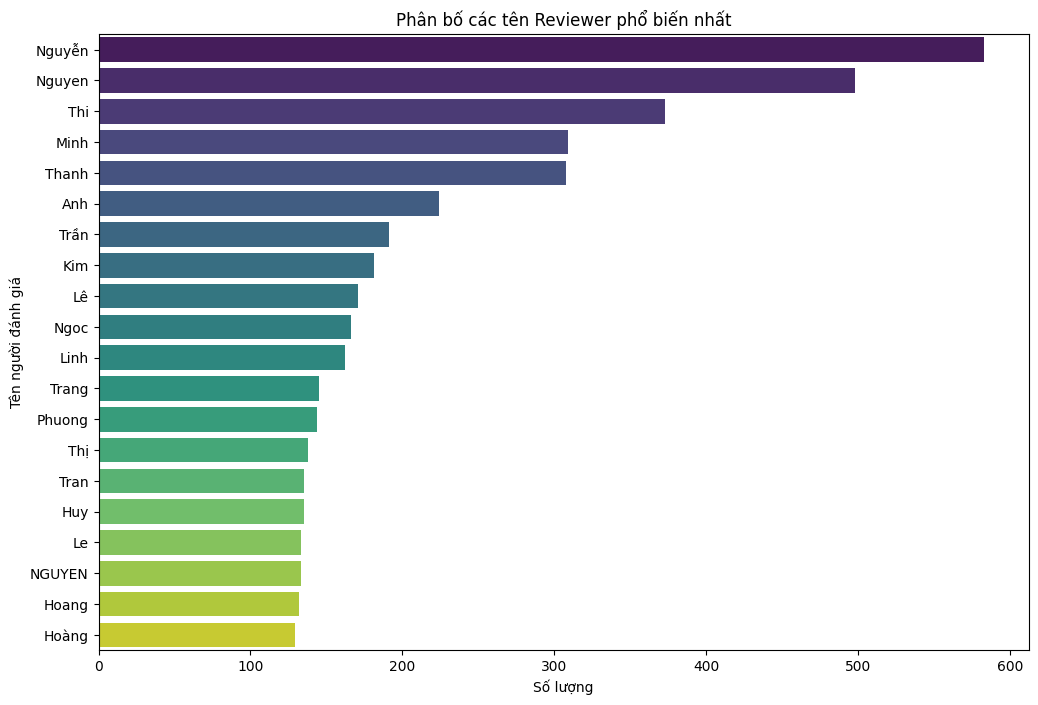

In [34]:
# Tạo biểu đồ cột
plt.figure(figsize=(12, 8))
sns.barplot(x=top_names.values, y=top_names.index, palette="viridis")
plt.xlabel('Số lượng')
plt.ylabel('Tên người đánh giá')
plt.title('Phân bố các tên Reviewer phổ biến nhất')
plt.show()

Tuy nhiên khi xem file csv thì thấy review_name dữ liệu khá lôn xộn,nên có thể lower tất cả rồi xét trùng lặp trường hợp 2 lần nauwx thì dữ liệu sẽ tinh gon hơn!!

In [35]:
# Xem tất cả các giá trị duy nhất trong cột 'Score'
unique_scores = hotel_comments_clean['Score'].unique()
print(unique_scores)

['8,8' '10,0' '8,0' '9,2' '9,6' '8,4' '7,6' '6,4' '7,2' '6,8' '8,7' '7,7'
 '9,5' '9,7' '6,7' '6,3' '9,0' '7,5' '8,3' '9,3' '7,3' '7,0']


In [36]:
# Thay thế dấu phẩy bằng dấu chấm
hotel_comments_clean['Score'] = hotel_comments_clean['Score'].astype(str).str.replace(',', '.')
# Chuyển đổi cột sang kiểu float
hotel_comments_clean['Score'] = pd.to_numeric(hotel_comments_clean['Score'], errors='coerce')

In [37]:
hotel_comments_clean['Score'].dtype

dtype('float64')

In [38]:
# Lọc những hàng có giá trị NaN ở cả 'Reviewer Name' và 'Score'
nan_count = hotel_comments_clean[hotel_comments_clean[['Reviewer Name', 'Score']].isna().all(axis=1)].shape[0]

In [39]:
nan_count

0

Su dung package cua bên trung tâm

In [40]:
from analysis.analyzer import TTTH_Analyzer as Analyzer

In [41]:
_analyzer = Analyzer()

=====
central tendency of Score: {'mean': 9.234340703549934, 'median': 9.6, 'mode': 10.0, 'min': 6.3, 'max': 10.0, 'range': 3.7}
=====
Dispersion of Score: 
 {'range': 3.7, 'q1': 8.8, 'q3': 10.0, 'iqr': 1.1999999999999993, 'var': 0.9776027830483492, 'skew': -1.2262131754713717, 'kurtosis': 0.48745018174713994}
=====


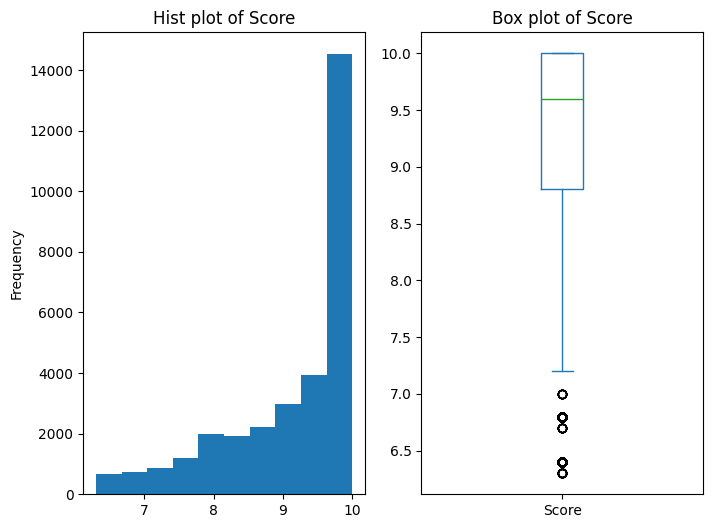

In [42]:
# Biến numeric: Score
_analyzer.analyze_numeric_variable(variable_name='Score', df=hotel_comments_clean)

Score 10 chiem so luong kha nhieu

In [43]:
_analyzer.check_imbalance_class(variable_name='Score', df=hotel_comments_clean)

Class count of Score:

Score
10.0    0.466770
9.6     0.126452
9.2     0.095137
8.8     0.071224
8.0     0.064111
8.4     0.060893
7.6     0.037430
7.2     0.027389
6.8     0.022819
6.4     0.021209
8.3     0.001094
7.7     0.000901
9.0     0.000740
8.7     0.000740
6.3     0.000676
9.7     0.000644
9.3     0.000644
7.3     0.000418
6.7     0.000322
7.0     0.000290
9.5     0.000064
7.5     0.000032
Name: proportion, dtype: float64
Ratio of 2 class is 14503.0
You should consider to handle imbalance


In [44]:
data_hotel_rw= hotel_comments_clean[['Hotel ID', 'Reviewer ID', 'Score']]

In [45]:
data_hotel_rw

,Hotel ID,Reviewer ID,Score
1033,1_1,1_1_1034,8.8
1034,1_1,1_1_1035,10.0
1035,1_1,1_1_1036,10.0
1036,1_1,1_1_1037,10.0
1037,1_1,1_1_1038,8.0
...,...,...,...
80309,43_29,43_29_7,8.8
80310,43_29,43_29_8,9.6
80311,43_29,43_29_9,8.4
80312,43_29,43_29_10,7.6


In [46]:
data_hotel_rw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31071 entries, 1033 to 80313
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hotel ID     31071 non-null  object 
 1   Reviewer ID  31071 non-null  object 
 2   Score        31071 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [80]:
#Lưu lại file
data_hotel_rw.to_csv("hotel_review_clean.csv", index=False)

### SurPrise

Chuyển đổi Hotel_ID và Reviewer_ID thành kiểu số

In [48]:
from sklearn.preprocessing import LabelEncoder
from surprise import Dataset, Reader

In [49]:
hotel_encoder = LabelEncoder()
reviewer_encoder = LabelEncoder()

In [50]:
# Chuyển đổi cột 'Hotel_ID' và 'Reviewer_ID' thành số
data_hotel_rw['Hotel ID_Encoded'] = hotel_encoder.fit_transform(data_hotel_rw['Hotel ID'])
data_hotel_rw['Reviewer ID_Encoded'] = reviewer_encoder.fit_transform(data_hotel_rw['Reviewer ID'])

In [51]:
data_hotel_rw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31071 entries, 1033 to 80313
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hotel ID             31071 non-null  object 
 1   Reviewer ID          31071 non-null  object 
 2   Score                31071 non-null  float64
 3   Hotel ID_Encoded     31071 non-null  int32  
 4   Reviewer ID_Encoded  31071 non-null  int32  
dtypes: float64(1), int32(2), object(2)
memory usage: 2.2+ MB


In [52]:
reader = Reader(rating_scale=(data_hotel_rw['Score'].min(), data_hotel_rw['Score'].max()))
data = Dataset.load_from_df(data_hotel_rw[['Reviewer ID_Encoded', 'Hotel ID_Encoded', 'Score']], reader)

In [53]:
from surprise import Dataset, Reader, SVD, KNNBasic,NMF
from surprise.model_selection import cross_validate,train_test_split

In [54]:
# # Chọn thuật toán
# algorithms = {
#     'SVD': SVD(),
#     'KNNBasic': KNNBasic(),
#     'NMF': NMF()}

# # Đánh giá từng thuật toán
# for name, algo in algorithms.items():
#     print(f"Evaluating {name}:")
#     results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

#     print(f"Results for {name}:")
#     print(f"RMSE: {results['test_rmse'].mean()}")
#     print(f"MAE: {results['test_mae'].mean()}")

SVD (Singular Value Decomposition)

In [55]:
svd = SVD()
results_svd= cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9252  0.9418  0.9308  0.9424  0.9206  0.9322  0.0087  
MAE (testset)     0.7407  0.7506  0.7423  0.7546  0.7422  0.7461  0.0055  
Fit time          0.45    0.45    0.45    0.54    0.45    0.47    0.04    
Test time         0.04    0.05    0.11    0.04    0.04    0.06    0.03    


In [56]:
results_svd

{'test_rmse': array([0.92523377, 0.94183056, 0.93082374, 0.94244981, 0.920605  ]),
 'test_mae': array([0.7407419 , 0.75057487, 0.74232763, 0.75461695, 0.74215889]),
 'fit_time': (0.4500610828399658,
  0.4462440013885498,
  0.4496629238128662,
  0.5435588359832764,
  0.44783878326416016),
 'test_time': (0.03586244583129883,
  0.052472591400146484,
  0.10683703422546387,
  0.04305124282836914,
  0.03799581527709961)}

NMF (Non-negative Matrix Factorization)

In [57]:
nmf = NMF()
results_nmf= cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5912  1.6207  1.5802  1.6097  1.5897  1.5983  0.0147  
MAE (testset)     1.2117  1.2309  1.1976  1.2181  1.2022  1.2121  0.0118  
Fit time          1.85    1.95    2.63    1.80    2.36    2.12    0.32    
Test time         0.04    0.10    0.05    0.08    0.05    0.07    0.02    


In [58]:
results_nmf

{'test_rmse': array([1.59122086, 1.620669  , 1.58021817, 1.60974804, 1.58970086]),
 'test_mae': array([1.21168617, 1.23093912, 1.19755791, 1.21811246, 1.20221703]),
 'fit_time': (1.8517844676971436,
  1.9471709728240967,
  2.6263034343719482,
  1.8018457889556885,
  2.3555893898010254),
 'test_time': (0.038234710693359375,
  0.10428094863891602,
  0.05098247528076172,
  0.08344030380249023,
  0.048065185546875)}

KNNBasic (K-Nearest Neighbors)

In [59]:
sim_options = {
    'name': 'cosine',  # Hoặc 'pearson' cho phương pháp tính tương đồng
    'user_based': False  # True  dựa trên người dùng, False nếu dựa trên mặt hàng
    }
# Tạo mô hình KNN
model = KNNBasic(sim_options=sim_options)

In [60]:
results_knn = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8742  0.8838  0.8798  0.8759  0.8904  0.8808  0.0058  
MAE (testset)     0.6407  0.6420  0.6461  0.6389  0.6493  0.6434  0.0038  
Fit time          0.01    0.02    0.03    0.02    0.02    0.02    0.01    
Test time         0.07    0.06    0.08    0.06    0.08    0.07    0.01    


In [61]:
results_knn

{'test_rmse': array([0.87423985, 0.88378007, 0.87979655, 0.87585434, 0.89038752]),
 'test_mae': array([0.64074895, 0.64202809, 0.64613116, 0.63889882, 0.64927812]),
 'fit_time': (0.012021541595458984,
  0.0220797061920166,
  0.02706742286682129,
  0.016620397567749023,
  0.017815113067626953),
 'test_time': (0.06654047966003418,
  0.06096196174621582,
  0.0812685489654541,
  0.06142115592956543,
  0.07810425758361816)}

Phân tích và đánh giá
1. SVD (Singular Value Decomposition)
RMSE & MAE: Độ chính xác trung bình, tốt hơn NMF nhưng kém hơn KNNBasic.
Thời gian huấn luyện: Trung bình, lâu hơn KNNBasic.
Thời gian dự đoán: Nhanh và ổn định.

2. NMF (Non-negative Matrix Factorization)
RMSE & MAE: Kém nhất trong ba thuật toán, cho thấy độ chính xác thấp nhất.
Thời gian huấn luyện: Lâu nhất.
Thời gian dự đoán: Nhanh nhưng kém hơn KNNBasic.

3. KNNBasic (K-Nearest Neighbors Basic)
RMSE & MAE: Độ chính xác cao nhất, sai số dự đoán thấp nhất.
Thời gian huấn luyện: Nhanh nhất.
Thời gian dự đoán: Nhanh và ổn định.

Kết luận 

SVD là lựa chọn tốt nhất về hiệu suất dự đoán.
KNNBasic có thời gian huấn luyện nhanh nhất và tương đương về độ chính xác với NMF.
NMF có hiệu suất kém hơn cả SVD và KNNBasic nhưng có thời gian huấn luyện lâu hơn.

Chọn SVD để build model

In [62]:
#getting full dataset => fit model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [63]:
data_hotel_rw.head()

,Hotel ID,Reviewer ID,Score,Hotel ID_Encoded,Reviewer ID_Encoded
1033,1_1,1_1_1034,8.8,156,6385
1034,1_1,1_1_1035,10.0,156,6386
1035,1_1,1_1_1036,10.0,156,6387
1036,1_1,1_1_1037,10.0,156,6388
1037,1_1,1_1_1038,8.0,156,6389


In [64]:
user_id = 7396

# Filter data for the specific user with scores greater than or equal to 
df_select = data_hotel_rw[(data_hotel_rw['Reviewer ID_Encoded'] == user_id) & (data_hotel_rw['Score'] >= 8)]

# Set 'Hotel ID_Encoded' as the index
df_select = df_select.set_index('Hotel ID_Encoded')

# Display the filtered DataFrame
print(df_select.head(df_select.shape[0]))


                 Hotel ID Reviewer ID  Score  Reviewer ID_Encoded
Hotel ID_Encoded                                                 
172                  1_24   1_24_1384    9.6                 7396


In [65]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [66]:
model = SVD()
model.fit(trainset)

In [67]:
predictions = model.test(testset)

In [68]:
from surprise import accuracy

In [69]:
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.9372
MAE:  0.7515
RMSE: 0.9371934472647147
MAE: 0.7515490789946854


In [70]:
def get_recommendations_for_user(reviewer_id, model, data, num_recommendations=5):
    # Tạo tập dữ liệu từ DataFrame
    reader = Reader(rating_scale=(data['Score'].min(), data['Score'].max()))
    dataset = Dataset.load_from_df(data[['Reviewer ID_Encoded', 'Hotel ID_Encoded', 'Score']], reader)
    
    # Chia dữ liệu thành trainset và testset
    trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)
    
    # Huấn luyện mô hình
    model.fit(trainset)
    
    # Lấy tất cả các khách sạn có thể gợi ý
    all_hotel_ids = set(data['Hotel ID_Encoded'])
    
    # Lấy các khách sạn đã được người dùng đánh giá
    rated_hotel_ids = set(data[data['Reviewer ID_Encoded'] == reviewer_id]['Hotel ID_Encoded'])
    
    # Tạo danh sách các khách sạn chưa được đánh giá
    unrated_hotel_ids = all_hotel_ids - rated_hotel_ids
    
    # Dự đoán điểm số cho các khách sạn chưa được đánh giá
    predictions = []
    for hotel_id in unrated_hotel_ids:
        pred = model.predict(reviewer_id, hotel_id)
        predictions.append((reviewer_id, pred.est))
    
    # Sắp xếp các dự đoán theo điểm số giảm dần
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Lấy top num_recommendations
    top_recommendations = predictions[:num_recommendations]
    
    return top_recommendations


In [71]:
# def get_recommendations_for_user(reviewer_id, model, data, num_recommendations=5):
#     # Create a list of all hotel IDs
#     all_hotel_ids = set(data['Hotel ID_Encoded'])
    
#     # Get the list of hotels already rated by the user
#     rated_hotel_ids = set(data[data['Reviewer ID_Encoded'] == reviewer_id]['Hotel ID_Encoded'])
    
#     # Calculate the list of unrated hotels
#     unrated_hotel_ids = all_hotel_ids - rated_hotel_ids
    
#     # Predict ratings for unrated hotels
#     predictions = []
#     for hotel_id in unrated_hotel_ids:
#         # Predict the rating for this hotel by this user
#         pred = model.predict(reviewer_id, hotel_id)
#         predictions.append((hotel_id, pred.est))
    
#     # Sort predictions by estimated rating in descending order
#     predictions.sort(key=lambda x: x[1], reverse=True)
    
#     # Return top recommendations
#     top_recommendations = predictions[:num_recommendations]
    
#     return top_recommendations

In [72]:
data_hotel_rw

,Hotel ID,Reviewer ID,Score,Hotel ID_Encoded,Reviewer ID_Encoded
1033,1_1,1_1_1034,8.8,156,6385
1034,1_1,1_1_1035,10.0,156,6386
1035,1_1,1_1_1036,10.0,156,6387
1036,1_1,1_1_1037,10.0,156,6388
1037,1_1,1_1_1038,8.0,156,6389
...,...,...,...,...,...
80309,43_29,43_29_7,8.8,365,21172
80310,43_29,43_29_8,9.6,365,21173
80311,43_29,43_29_9,8.4,365,21174
80312,43_29,43_29_10,7.6,365,21165


In [75]:
# input review_id
reviewer_id = 7396
recommendations = get_recommendations_for_user(reviewer_id, model, data_hotel_rw, num_recommendations=5)

# Print the top 5 recommendations 
print(f"Top Recommendations for User: {reviewer_id}")
for rec in recommendations:
    print(f"Hotel ID_encoder: {rec[0]}, Predicted Score: {rec[1]:.2f}")


Top Recommendations for User: 7396
Hotel ID_encoder: 188, Predicted Score: 9.75
Hotel ID_encoder: 186, Predicted Score: 9.74
Hotel ID_encoder: 237, Predicted Score: 9.71
Hotel ID_encoder: 103, Predicted Score: 9.69
Hotel ID_encoder: 176, Predicted Score: 9.68


ALS

In [74]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [125]:
hotel_rw = spark.read.csv("hotel_review_clean.csv", header=True, inferSchema=True)

In [126]:
hotel_rw.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer ID: string (nullable = true)
 |-- Score: double (nullable = true)
 |-- Hotel ID_Encoded: integer (nullable = true)
 |-- Reviewer ID_Encoded: integer (nullable = true)



In [127]:
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import isnan, when, count, col

In [128]:
# Kiểm tra số lượng giá trị NaN trong từng cột
nan_counts = hotel_rw.select([count(when(col(c).isNull(), c)).alias(c) for c in hotel_rw.columns])
nan_counts.toPandas().T

,0
Hotel ID,0
Reviewer ID,0
Score,0
Hotel ID_Encoded,0
Reviewer ID_Encoded,0


In [129]:
# Check duplicate
num_rows = hotel_rw.count()
num_dist_rows = hotel_rw.distinct().count()
dup_rows = num_rows - num_dist_rows
dup_rows

0

In [130]:
# Distinct hotel id and reviewer id
users = hotel_rw.select("Reviewer ID").distinct().count()
products = hotel_rw.select("Hotel ID").distinct().count()
numerator = hotel_rw.count()

In [131]:
display(numerator, users, products)

31071

26927

473

In [132]:
denominator = users * products
denominator

12736471

In [133]:
#Calculate sparsity
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: ", sparsity)

Sparsity:  0.997560470243288


Kết quả Sparsity: 0.997560470243288 cho thấy độ thưa thớt của ma trận đánh giá là khoảng 99.76%. 
Đây là một giá trị rất cao, cho thấy rằng phần lớn ma trận đánh giá không có giá trị.

In [124]:
hotel_rw.show()

+--------+-----------+-----+----------------+-------------------+
|Hotel ID|Reviewer ID|Score|Hotel ID_Encoded|Reviewer ID_Encoded|
+--------+-----------+-----+----------------+-------------------+
|     1_1|   1_1_1034|  8.8|             156|               6385|
|     1_1|   1_1_1035| 10.0|             156|               6386|
|     1_1|   1_1_1036| 10.0|             156|               6387|
|     1_1|   1_1_1037| 10.0|             156|               6388|
|     1_1|   1_1_1038|  8.0|             156|               6389|
|     1_1|   1_1_1039|  8.8|             156|               6390|
|     1_1|   1_1_1040|  9.2|             156|               6391|
|     1_1|   1_1_1041|  9.6|             156|               6392|
|     1_1|   1_1_1042|  8.0|             156|               6393|
|     1_1|   1_1_1043|  8.4|             156|               6394|
|     1_1|   1_1_1044| 10.0|             156|               6395|
|     1_1|   1_1_1045| 10.0|             156|               6396|
|     1_1|

In [134]:
# Chia mẫu train, test theo tỷ lệ 0.8/0.2
train_data, test_data = hotel_rw.randomSplit([0.8, 0.2], seed=42)

In [135]:
from datetime import datetime
start_time = datetime.now()

In [146]:
als = ALS(
    maxIter=10,     
    regParam=0.1,             
    userCol="Reviewer ID_Encoded", 
    itemCol="Hotel ID_Encoded", 
    ratingCol="Score",
    coldStartStrategy="drop"
)

In [147]:
# Huấn luyện mô hình trên dữ liệu
model = als.fit(hotel_rw)

In [148]:
model = als.fit(train_data)

In [149]:
end_time = datetime.now()

In [150]:
print('Execute time {}'.format(end_time- start_time))

Execute time 0:01:45.175118


thời gian huấn luyện mất tầm 1p45s

In [151]:
predictions = model.transform(test_data)

In [152]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Score",
    predictionCol="prediction"
)

In [153]:
rmse = evaluator.evaluate(predictions)
rmse

0.15863761812727084

In [155]:
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.15863761812727084


RMSE
Surprise:0.93
ALS:0.15
cho thấy ALS cho kết quả dự đoán gần với giá trị thực tế hơn.

Bước 3: Khuyến nghị sản phẩm cho người dùng và khuyến nghị người dùng cho sản phẩm.

In [162]:
# Tạo ra top 10 hotel khuyến nghị cho mỗi một reviewer_id
userRecs = model.recommendForAllUsers(10)
userRecs.show(10, truncate=False)

+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Reviewer ID_Encoded|recommendations                                                                                                                                                               |
+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26                 |[{288, 11.604899}, {280, 11.604899}, {365, 11.250664}, {326, 10.626122}, {379, 10.608064}, {396, 10.596246}, {397, 9.945504}, {351, 9.923619}, {312, 9.923619}, {9, 9.923619}]|
|27                 |[{288, 11.604899}, {280, 11.604899}, {365, 11.250664}, {326, 10.626122}, {379, 10.608064}, {396, 10.596246}, {397, 9.945504}, {351, 9.923619}, {312, 9.923619}, {9, 9.923619}]|
|28            

In [163]:
# Tạo ra top 10 user khuyến nghị cho mỗi một hotel
hotelRecs = model.recommendForAllItems(10)
hotelRecs.show(10, truncate=False)

+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Hotel ID_Encoded|recommendations                                                                                                                                                                                         |
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0               |[{23343, 11.078641}, {23341, 11.078641}, {23337, 11.078641}, {23336, 11.078641}, {23326, 11.078641}, {23324, 11.078641}, {23323, 11.078641}, {23319, 11.078641}, {23314, 11.078641}, {23313, 11.078641}]|
|1               |[{1446, 14.376967}, {1441, 14.376967}, {1437, 14.376967}, {1436, 14.376967}, {1435, 14.376967}, {1434,

In [178]:
# Lấy danh sách các Reviewer_ID cụ thể 
user_ids = hotel_rw.select("Reviewer ID_Encoded").distinct().limit(3)
user_ids.show()

+-------------------+
|Reviewer ID_Encoded|
+-------------------+
|               6397|
|               6466|
|               8592|
+-------------------+

